<span style="font-size: 30px;">**Assignment - GROUP 8**</span>


In [122]:
#TAN KAI LOON TP063793
#TAN JIA JUN TP063792
#GELLS TAN YIN ZHAO TP063787

In [1]:
#Read data
import pandas as pd
import numpy as np
import nltk 
import plotly.express as px
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from langdetect import detect
from collections import Counter


original_data=pd.read_csv("C:\\Users\\user10\\Desktop\APU Year 3 Degree Semester 1\\Text Analytics and Sentiment Analysis\\Group Assignment\\dataset part B Group 8.csv",encoding="utf-8")
data=original_data.copy()


In [132]:
data.shape

(5728, 2)

In [133]:
temp = data.groupby('spam').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Blues')

,spam,text
0,0,4360
1,1,1368


Check if the text is all in English or not

In [134]:
#Language detection
data['langue'] = data['text'].apply(detect)

# Filter non-English texts
non_english_texts = data[data['langue'] != 'en']

# Count the number of rows that weren't in English
num_non_english_rows = non_english_texts.shape[0]
print(f"Number of rows that weren't in English: {num_non_english_rows}")

# Display the non-English texts
print(non_english_texts[['text', 'langue']])

Number of rows that weren't in English: 49
                                                   text langue
69    Subject: quelqu ' un t ' aime en secret  quelq...     fr
333   Subject: benachrichtung  zum  ( fehlgeschlagen...     de
431   Subject: kime oy vereceksiniz ?  ?yi g?nler  d...     tr
488   Subject: kit torre empilhadeira savi  santos ,...     pt
568                                  Subject: . jif  .      hr
592   Subject: free lancer eventos  free lancer even...     pt
631      Subject: discreet penis enlargement 4623  4623     nl
693   Subject: neugierig ?  - - - - 870879228701464 ...     de
764   Subject: ) .  your message  subject : just to ...     fr
874   Subject: = ? iso - 8859 - 1 ? q ? clausura _ c...     es
892   Subject: proteja su negocio ! ! cctv , alarmas...     es
1163  Subject: een avontuurtje is oke ,  als je dit ...     nl
1239  Subject: roletes e roldanas para empilhadeiras...     pt
1291  Subject: de la part des enfants ama  rue des m...     fr
1299  Subjec

Update data with English

In [135]:
# Update the original DataFrame to include only English texts
data = data[data['langue'] == 'en']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5679 entries, 0 to 5727
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5679 non-null   object
 1   spam    5679 non-null   int64 
 2   langue  5679 non-null   object
dtypes: int64(1), object(2)
memory usage: 177.5+ KB


Display Top 10 row 

In [136]:
data.head(10)

,text,spam,langue
0,Subject: naturally irresistible your corporate...,1,en
1,Subject: the stock trading gunslinger fanny i...,1,en
2,Subject: unbelievable new homes made easy im ...,1,en
3,Subject: 4 color printing special request add...,1,en
4,"Subject: do not have money , get software cds ...",1,en
5,"Subject: great nnews hello , welcome to medzo...",1,en
6,Subject: here ' s a hot play in motion homela...,1,en
7,Subject: save your money buy getting this thin...,1,en
8,Subject: undeliverable : home based business f...,1,en
9,Subject: save your money buy getting this thin...,1,en


Row and Column total number in data

In [137]:
data.shape

(5679, 3)

Check NULL values

In [138]:
data.isnull().sum()

text      0
spam      0
langue    0
dtype: int64

Check Duplicated values

In [139]:
data.duplicated().sum()

33

In [140]:
data=data.drop_duplicates(keep='first')
data.duplicated().sum()

0

In [141]:
data['num_characters'] = data['text'].apply(len)
data['num_words'] = data['text'].apply(lambda x: len(nltk.word_tokenize(x)))
data['num_sentence'] = data['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
data.head()

,text,spam,langue,num_characters,num_words,num_sentence
0,Subject: naturally irresistible your corporate...,1,en,1484,325,11
1,Subject: the stock trading gunslinger fanny i...,1,en,598,90,1
2,Subject: unbelievable new homes made easy im ...,1,en,448,88,4
3,Subject: 4 color printing special request add...,1,en,500,99,5
4,"Subject: do not have money , get software cds ...",1,en,235,53,9


In [142]:
##ham
data[data['spam'] == 0][['num_characters','num_words','num_sentence']].describe()

,num_characters,num_words,num_sentence
count,4293.000000,4293.000000,4293.000000
mean,1638.946424,348.387375,19.858141
std,1970.632312,408.346048,38.244774
min,13.000000,3.000000,1.000000
25%,582.000000,120.000000,7.000000
50%,1126.000000,241.000000,13.000000
75%,2041.000000,441.000000,22.000000
max,43952.000000,8479.000000,1565.000000


In [143]:
##spam
data[data['spam'] == 1][['num_characters','num_words','num_sentence']].describe()

,num_characters,num_words,num_sentence
count,1353.000000,1353.000000,1353.000000
mean,1320.497413,268.206948,18.264597
std,2280.884350,453.291261,28.224628
min,61.000000,12.000000,1.000000
25%,405.000000,81.000000,6.000000
50%,694.000000,141.000000,11.000000
75%,1238.000000,252.000000,18.000000
max,28432.000000,6131.000000,438.000000


<span style="font-size: 24px;">**Analyzing Text Statistics （EDA）**</span>


In [144]:
spam_category = data['spam'].value_counts()

fig = px.pie(values=spam_category.values, 
             names=spam_category.index, 
             color_discrete_sequence=px.colors.sequential.OrRd,
             title= 'Pie Graph: spam or ham,"1" represents spam, while "0" represents ham.')
fig.update_traces(hoverinfo='label+percent', textinfo='label+value+percent', textfont_size=15,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.show()

**1.2.1** Histograms of each numbers of characters in text

Character Length Distribution for Legitimate and Spam Messages

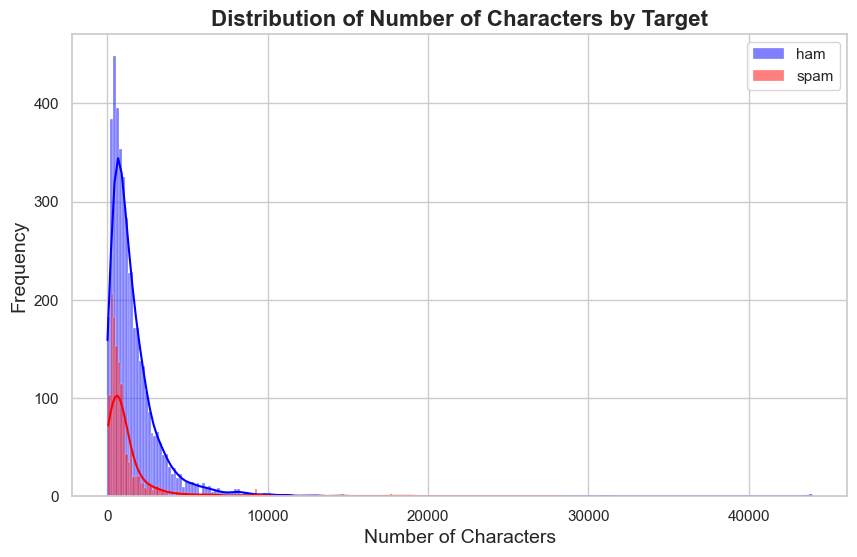

In [145]:
# Create a figure and set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram for target 0 in blue
sns.histplot(data[data['spam'] == 0]['num_characters'], color='blue', label='ham', kde=True)

# Plot the histogram for target 1 in red
sns.histplot(data[data['spam'] == 1]['num_characters'], color='red', label='spam', kde=True)

# Add labels and a title
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Number of Characters by Target', fontsize=16, fontweight='bold')

# Add a legend
plt.legend()

# Customize the appearance of the plot
sns.set(style='whitegrid')  # Add a white grid background

# Show the plot
plt.show()

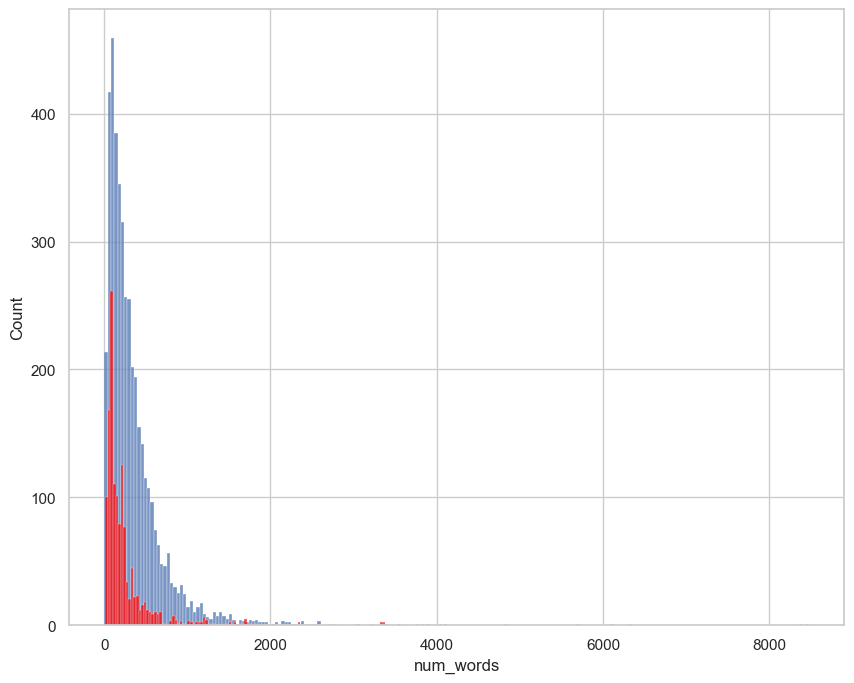

In [146]:
plt.figure(figsize=(10,8))
sns.histplot(data[data['spam'] == 0]['num_words'])
sns.histplot(data[data['spam'] == 1]['num_words'],color='red')
plt.show()

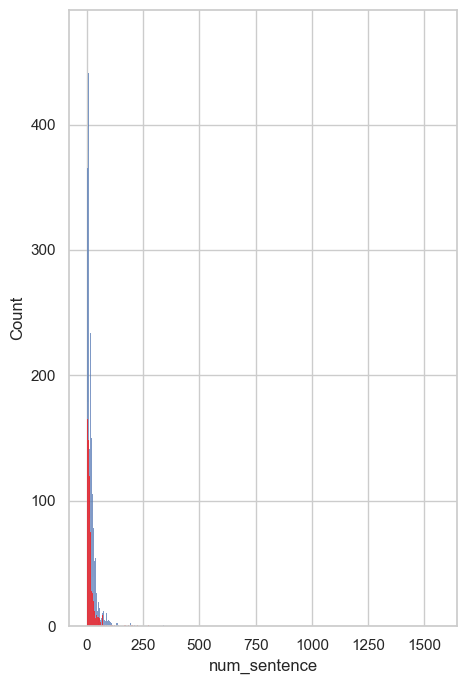

In [147]:
plt.figure(figsize=(5,8))
sns.histplot(data[data['spam'] == 0]['num_sentence'])
sns.histplot(data[data['spam'] == 1]['num_sentence'],color='red')
plt.show()

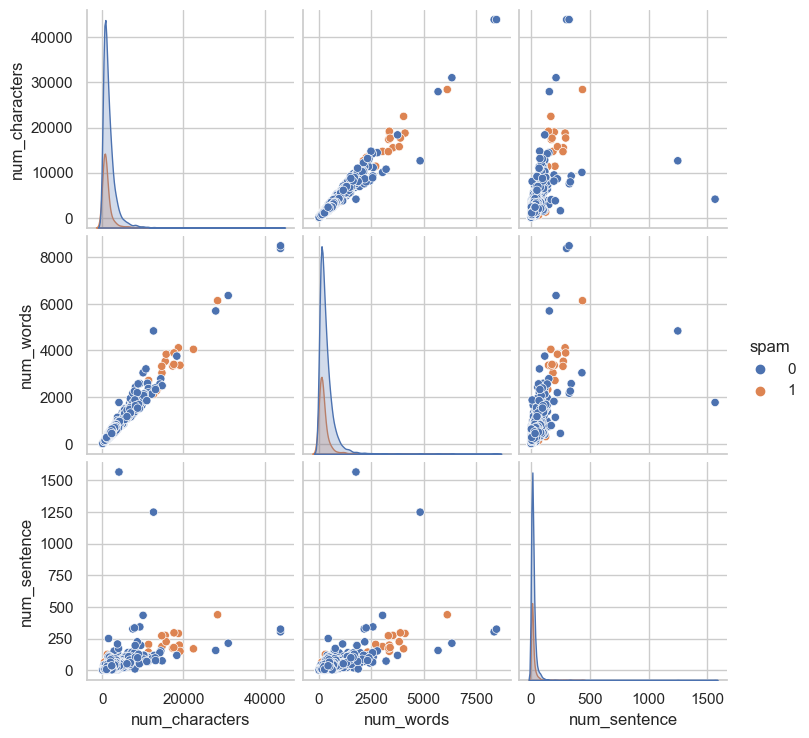

In [148]:
sns.pairplot(data, hue='spam')
plt.show()

C:\Users\user10\AppData\Local\Temp\ipykernel_24848\104075714.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



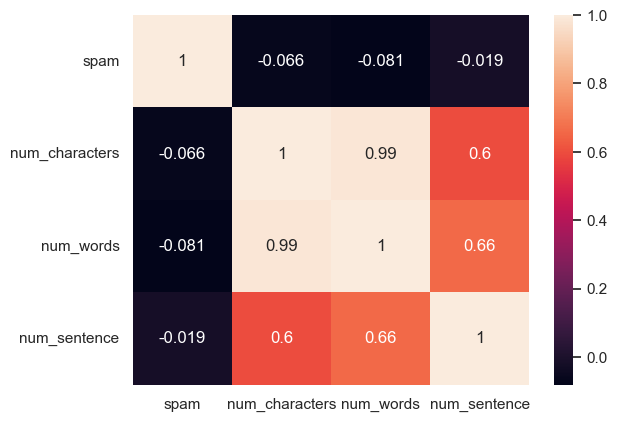

In [149]:
sns.heatmap(data.corr(), annot=True)
plt.show()

<AxesSubplot: xlabel='spam', ylabel='num_characters'>

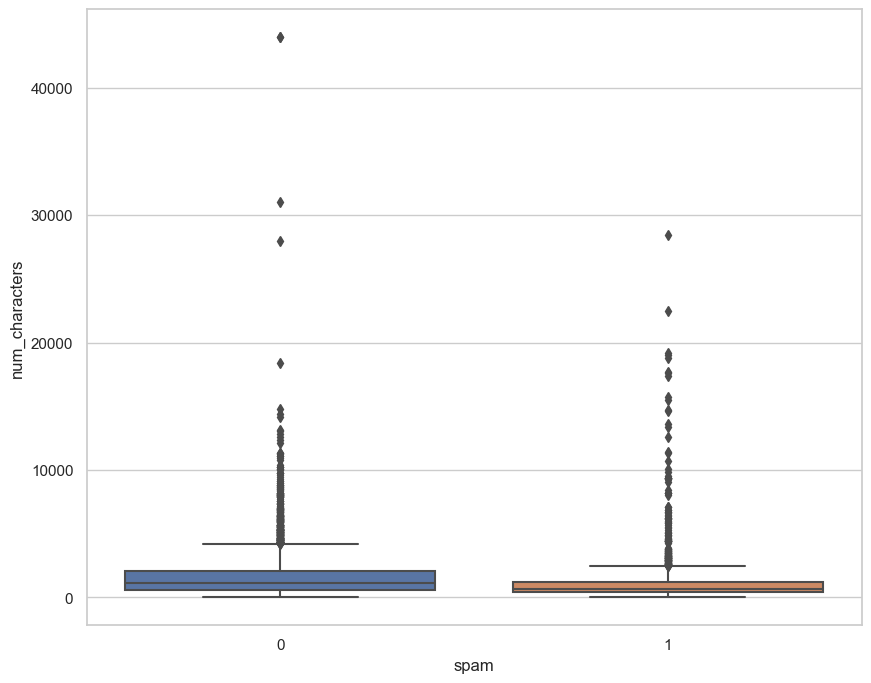

In [150]:
plt.figure(figsize=(10,8))
sns.boxplot(x='spam',y='num_characters',data=data)

Preprocessing

# Text Preprocessing Steps

1. **convert_to_lower**: Converts text to lowercase, ensuring uniformity in case.

2. **remove_numbers**: Removes numerical digits from the text.

3. **lemmatizing**: Performs lemmatization to reduce words to their base or root form.

4. **remove_punctuation**: Eliminates punctuation marks from the text.

5. **remove_stopwords**: Excludes common stop words from the text.

6. **stemming**: Reduces words to their root or stem using the Porter stemming algorithm.

7. **remove_extra_white_spaces**: Eliminates extra white spaces to maintain a clean format.

8. **remove_emoji**: Excludes emoji characters from the text.

9. **remove_username**: Removes @username mentions from the text.

10. **remove_html**: Removes HTML tags from the text.

11. **remove_url**: Removes URLs from the text.

12. **remove_word**: Removes specific words ('subject', 'mail', 'j') from the text.

13. **remove_solo_alphabets**: Removes standalone alphabets (except 'a' and 'i') from the text.

14. **abbreviation**: Expands common contractions and abbreviations.




In [151]:
# some text cleaning functions
stemmer=PorterStemmer()
spell_checker = SpellChecker()

def convert_to_lower(text):
    return text.lower()

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

# Remove @username
def remove_username(text):
    return re.sub('@[^\s]+','',text)

    # Remove url  
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')  
    return url.sub(r'',text)

def remove_word(text):
    # Use re.sub to remove "subject:" or "mail:" from the text
    updated_text = re.sub(r'\b(subject|mail|j)\b\s*', '', text, flags=re.IGNORECASE)
    return updated_text

def remove_solo_alphabets(text):
    # Use re.sub to replace standalone alphabets (except "a" and "i") with an empty string
    updated_text = re.sub(r'\b(?![ai]\b)[a-z]\b', '', text, flags=re.IGNORECASE)
    return updated_text

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    multiple_spaces_pattern = r'\s{2,}'
    without_multiple_spaces = re.sub(pattern=multiple_spaces_pattern, repl=" ", string=text)
    return without_multiple_spaces

def stemming(text):
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        stemmed_word = stemmer.stem(tokens[i])
        tokens[i] = stemmed_word if stemmed_word is not None else tokens[i]
    return " ".join(filter(None, tokens))

patterns = [
    (r"\b(u)\b\s", "you"),
    (r"won\'t", " will not"),
    (r"won\'t've", " will not have"),
    (r"can\'t", " can not"),
    (r"don\'t", " do not"),
    (r"can\'t've", " can not have"),
    (r"ma\'am", " madam"),
    (r"let\'s", " let us"),
    (r"ain\'t", " am not"),
    (r"shan\'t", " shall not"),
    (r"sha\n't", " shall not"),
    (r"o\'clock", " of the clock"),
    (r"y\'all", " you all"),
    (r"n\'t", " not"),
    (r"n\'t've", " not have"),
    (r"\'re", " are"),
    (r"\'s", " is"),
    (r"\'d", " would"),
    (r"\'d've", " would have"),
    (r"\'ll", " will"),
    (r"\'ll've", " will have"),
    (r"\'t", " not"),
    (r"\'ve", " have"),
    (r"\'m", " am"),
    (r"\'re", " are"),
]

def abbreviation(text):
    for pattern, replacement in patterns:
        text = re.sub(pattern, replacement, text)
    return text

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [152]:
# Calculate length before cleaning
data['length_before_cleaning'] = data['text'].apply(lambda x: len(x))

data['text'] = data['text'].apply(lambda x: convert_to_lower(x))
data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data['text'] = data['text'].apply(lambda x: abbreviation(x))
data['text'] = data['text'].apply(lambda x: remove_username(x))
data['text'] = data['text'].apply(lambda x: remove_punctuation(x))
data['text'] = data['text'].apply(lambda x: remove_url(x))
data['text'] = data['text'].apply(lambda x: remove_extra_white_spaces(x))
data['text'] = data['text'].apply(lambda x: remove_solo_alphabets(x))
data['text'] = data['text'].apply(lambda x: remove_word(x))
data['text'] = data['text'].apply(lambda x: remove_stopwords(x))
data['text'] = data['text'].apply(lambda x: lemmatizing(x))
data['text'] = data['text'].apply(lambda x: stemming(x))
data['text'] = data['text'].apply(lambda x: remove_emoji(x))

In [153]:

# calculating length of each record after performing text cleaning
data['length_after_cleaning'] = data['text'].apply(lambda x: len(x))
data.head()
     

,text,spam,langue,num_characters,num_words,num_sentence,length_before_cleaning,length_after_cleaning
0,natur irresist corpor ident lt realli hard rec...,1,en,1484,325,11,1484,760
1,stock trade gunsling fanni merril muzo colza a...,1,en,598,90,1,598,453
2,unbeliev new home made easi im want show homeo...,1,en,448,88,4,448,231
3,color print special request addit inform click...,1,en,500,99,5,500,271
4,money get softwar cd softwar compat great grow...,1,en,235,53,9,235,106


**1.2.2** WorldCloud

In [154]:
# setting specs of word cloud image
wc = WordCloud(width=1000, height=500, min_font_size=10, background_color='black')


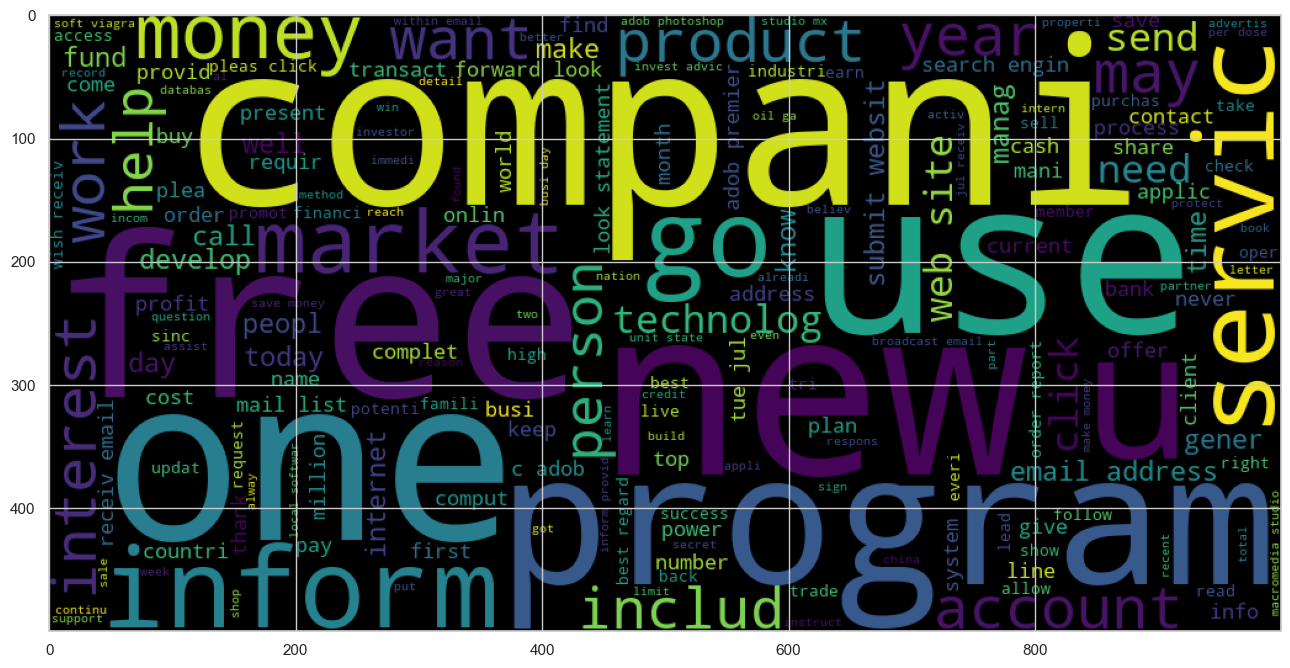

In [155]:
# creating word cloud of spam emails
spam_wc = wc.generate(data[data['spam'] == 1]['text'].str.cat(sep=' '))

plt.figure(figsize=(20,8))
plt.imshow(spam_wc)

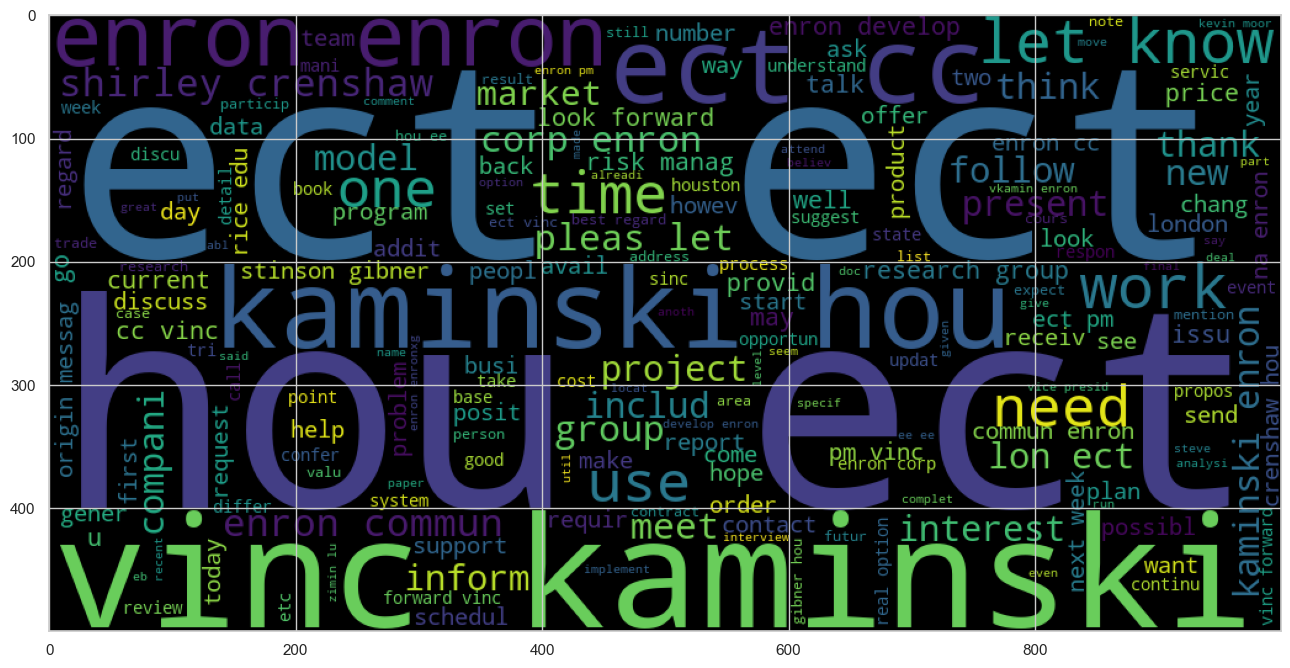

In [156]:
# creating word cloud of ham emails
ham_wc = wc.generate(data[data['spam'] == 0]['text'].str.cat(sep=' '))

plt.figure(figsize=(20,8))
plt.imshow(ham_wc)

In [157]:
# creating list of all the words in processed spam emails
spam_corpus = []
for mail in data[data['spam'] == 1]['text'].tolist():
    for word in mail.split():
        spam_corpus.append(word)

# number of words in all spam mails
len(spam_corpus)

153146

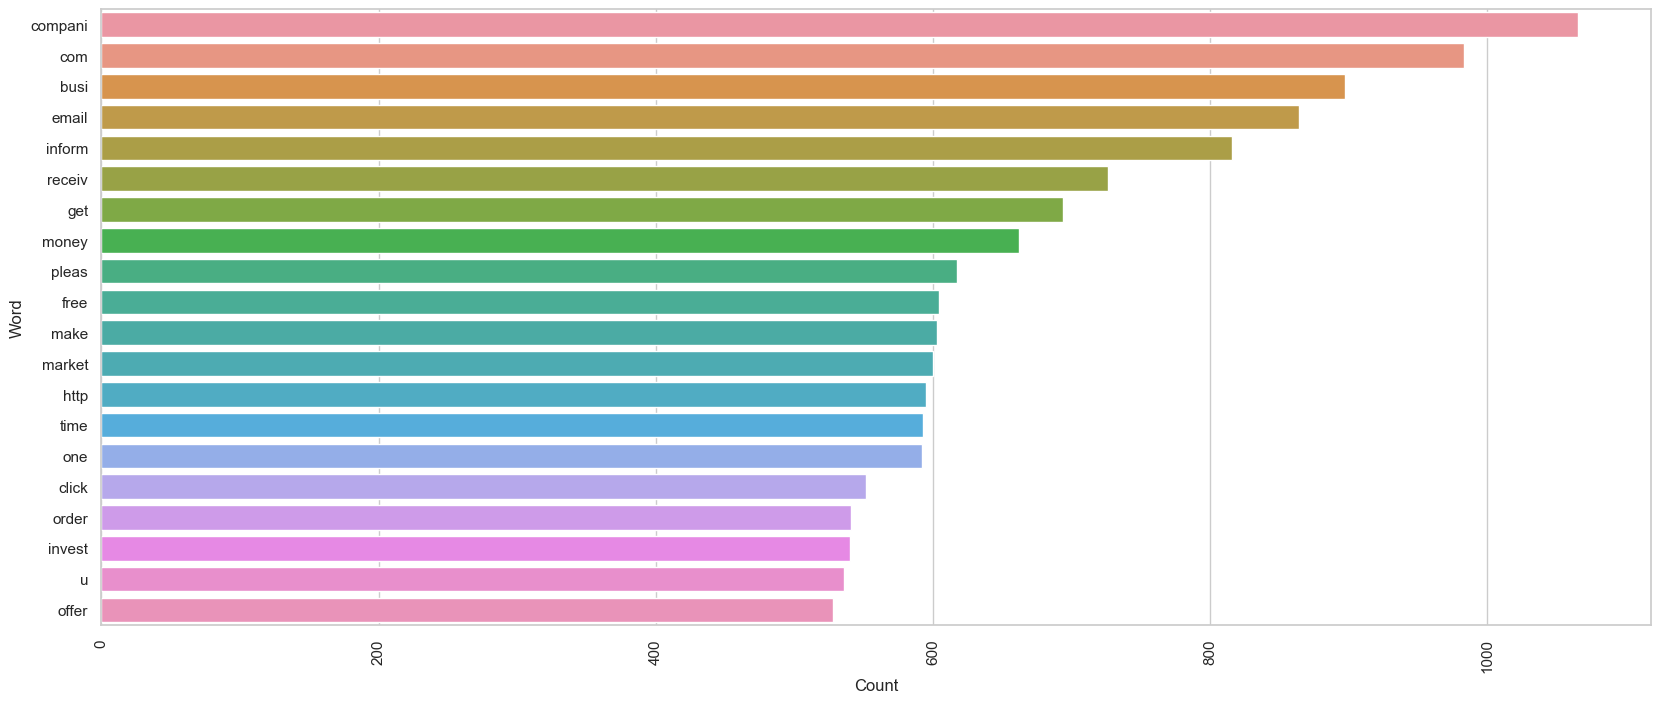

In [158]:
# top 20 most occurring words in spam mails
plt.figure(figsize=(20, 8))

# Create a DataFrame with the top 20 most common words and their counts
top_20_words_df = pd.DataFrame(Counter(spam_corpus).most_common(20), columns=['Word', 'Count'])

# Use Seaborn barplot
sns.barplot(x='Count', y='Word', data=top_20_words_df)
plt.xticks(rotation='vertical')
plt.show()


In [159]:
# creating list of all the words in processed spam emails
ham_corpus = []
for mail in data[data['spam'] == 0]['text'].tolist():
    for word in mail.split():
        ham_corpus.append(word)

# number of words in all spam mails
len(ham_corpus)

605730

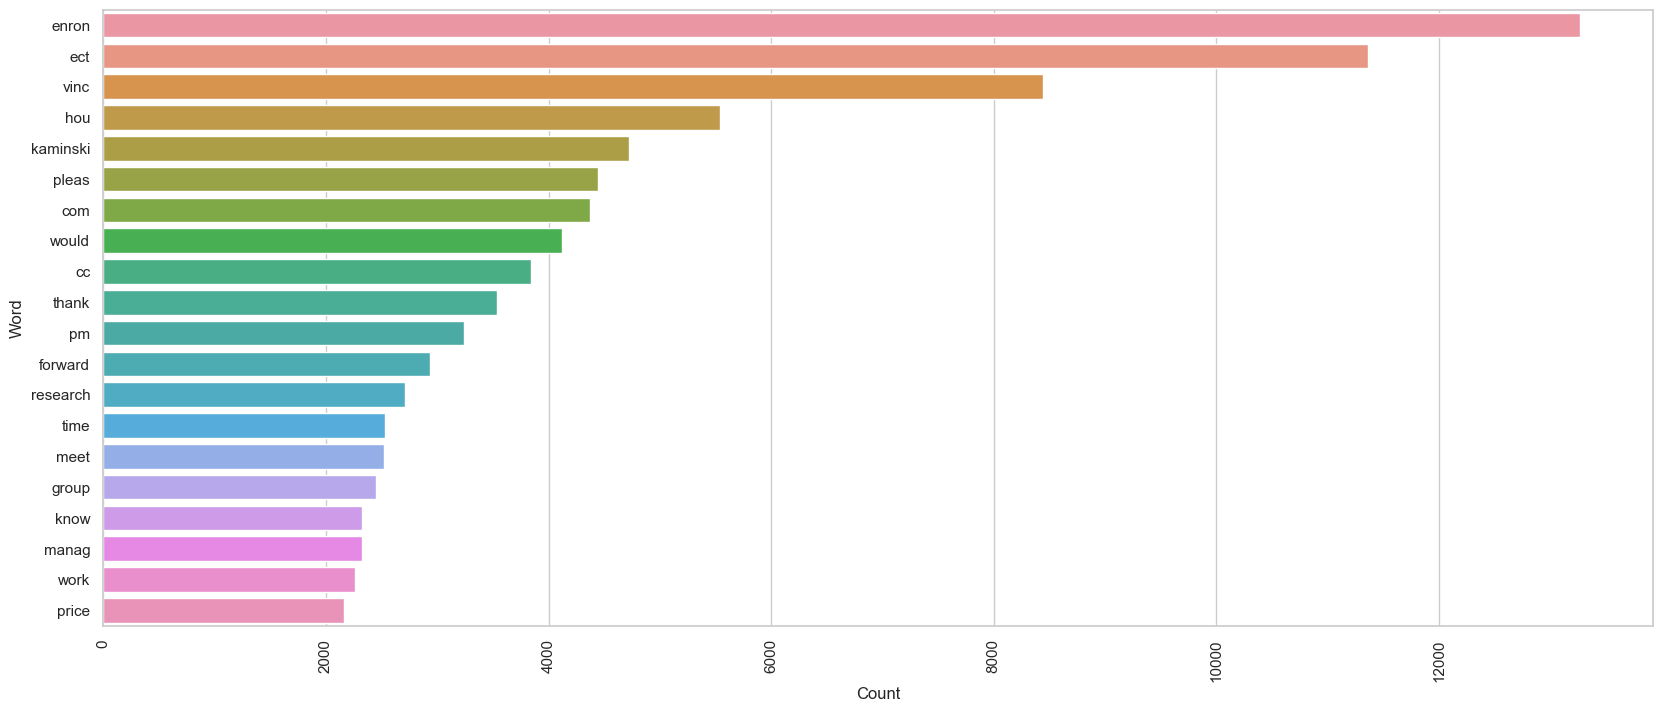

In [160]:
# top 20 most occurring words in spam mails
plt.figure(figsize=(20, 8))
# Create a DataFrame with the top 20 most common words and their counts
top_20_words_df = pd.DataFrame(Counter(ham_corpus).most_common(20), columns=['Word', 'Count'])

# Use Seaborn barplot
sns.barplot(x='Count', y='Word', data=top_20_words_df)
plt.xticks(rotation='vertical')
plt.show()


Balance data

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score # Performance Metrics  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [162]:
# Assuming your Excel file has columns named 'label' and 'text', update as needed
labels = data['spam']
texts = data['text']
y=labels
# Remove "Subject:" from the text
texts = texts.str.replace('Subject:', '', case=False)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.3)

# Text preprocessing using CountVectorizer (Random Forest & Naive Bayes)
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Text preprocessing using TfidfVectorizer (Decision Tree)
tfid = TfidfVectorizer()
X_train_tfidf = tfid.fit_transform(X_train)
X_test_tfidf = tfid.transform(X_test)

# Balancing the dataset using SMOTE (CountVectorizer)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_counts, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test_counts, y_test)

# Balancing the dataset using SMOTE (TfidfVectorizer)
X_train_resampled_tfid, y_train_resampled_tfid = smote.fit_resample(X_train_tfidf, y_train)
X_test_resampled_tfid, y_test_resampled_tfid = smote.fit_resample(X_test_tfidf, y_test)


Random Seach Hyperparameters ( Random Forest) (Q3)

In [163]:
rf = RandomForestClassifier()

# random search cv
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 30),
    'bootstrap': [True, False]
}

   
rf_random = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)
model_random = rf_random.fit(X_train_resampled,y_train_resampled)

# random random search results
print('Best random search of random forest hyperparameters are: '+str(model_random.best_params_))
print('Best random search of random forest score is: '+str(model_random.best_score_))

Best random search of random forest hyperparameters are: {'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 28, 'min_samples_split': 29, 'n_estimators': 24}
Best random search of random forest score is: 0.9489634905752788


In [164]:
#train the RandomForestClassifier with the best hyperparameters

rf_model = RandomForestClassifier(**model_random.best_params_)
rf_model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=28,
                       min_samples_split=29, n_estimators=24)

Learning Curve(Random Forest) (Q4)

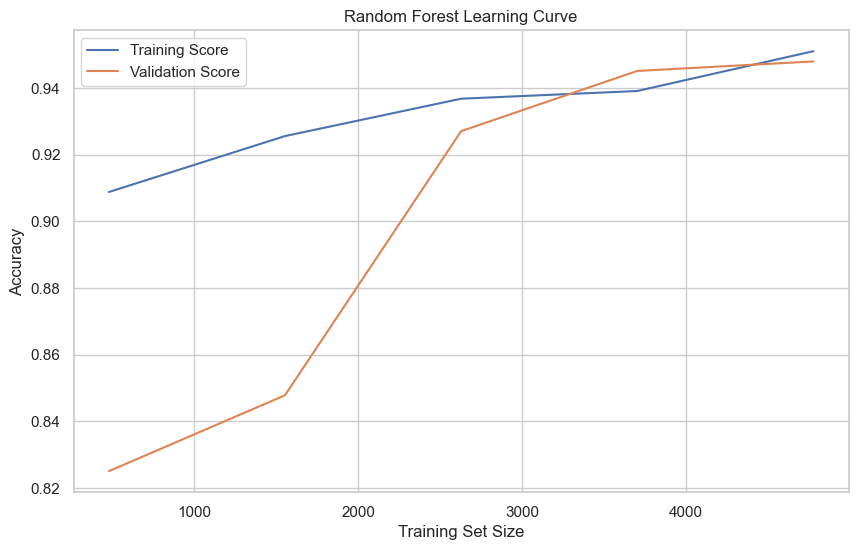

In [165]:
# Random Forest Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(rf_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy', n_jobs=-1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Random Forest Learning Curve')
plt.legend()
plt.show()

Confusion Matrix(Random Forest) (Q4)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      1305
           1       0.92      0.96      0.94      1305

    accuracy                           0.94      2610
   macro avg       0.94      0.94      0.94      2610
weighted avg       0.94      0.94      0.94      2610



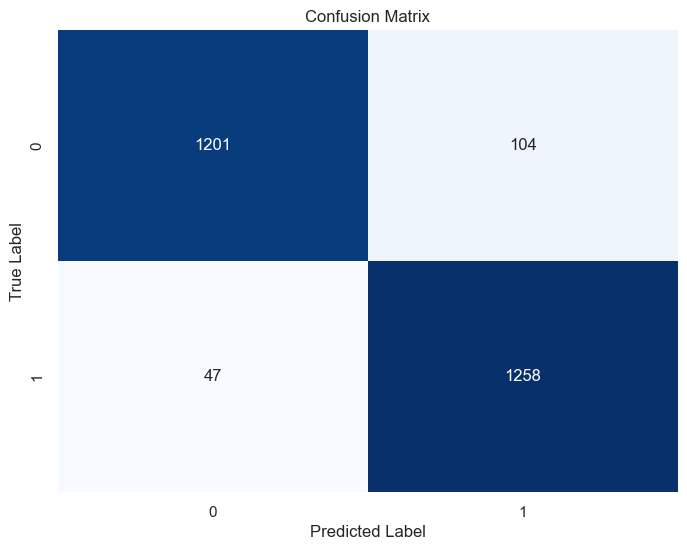

In [166]:
y_pred = rf_model.predict(X_test_resampled)
print("Classification Report:\n", classification_report(y_test_resampled, y_pred))
# Create a confusion matrix
cm = confusion_matrix(y_test_resampled, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Grid Search Hyperparameters(Naive_Bayes) (Q3)

In [167]:
# Define a range of values for alpha and other hyperparameters
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False],
    'class_prior': [None, [0.3, 0.7]]  # None means use uniform class prior
}


# Initialize the classifier
classifier = MultinomialNB()

# Perform grid search
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

# Access the best model
best_classifier = grid_search.best_estimator_

# Make predictions and evaluate
predictions = best_classifier.predict(X_test_resampled)
balanced_accuracy = balanced_accuracy_score(y_test_resampled, predictions)
report = classification_report(y_test_resampled, predictions)

print(f"Best Grid Search of Naive Bayes Accuracy: {balanced_accuracy:f}")
print(f"Best Grid Search of Naive Bayes Hyperparameters:",grid_search.best_params_)
print("Best Classification Report:\n", report)

Best Grid Search of Naive Bayes Accuracy: 0.983142
Best Grid Search of Naive Bayes Hyperparameters: {'alpha': 0.1, 'class_prior': [0.3, 0.7], 'fit_prior': True}
Best Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1305
           1       0.99      0.97      0.98      1305

    accuracy                           0.98      2610
   macro avg       0.98      0.98      0.98      2610
weighted avg       0.98      0.98      0.98      2610



Learning Curve (Naive_Bayes) (Q4)

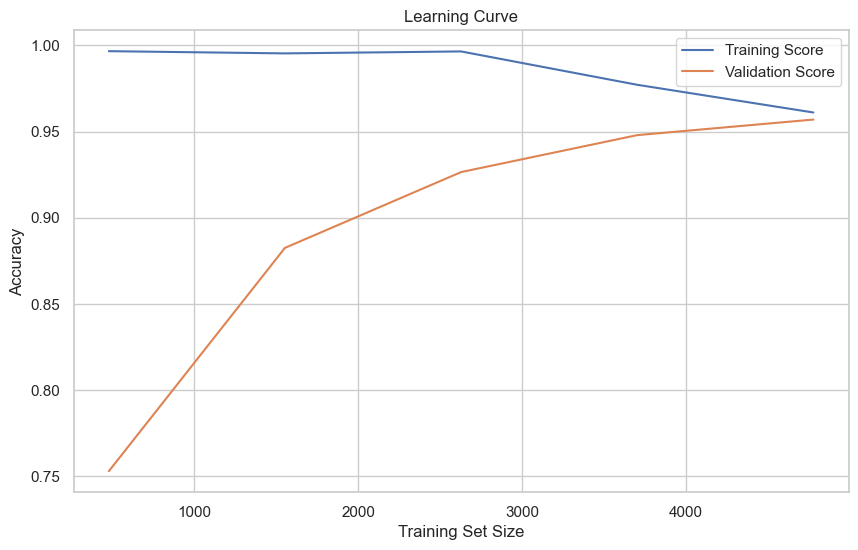

In [168]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(classifier, X_train_resampled, y_train_resampled, cv=5)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

Confusion Matrix(Naive_Bayes) (Q4)

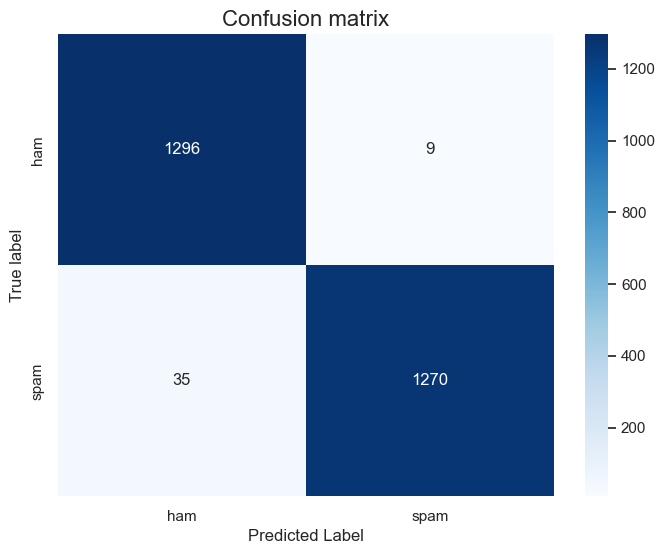

In [169]:
cmnb = confusion_matrix(y_test_resampled, predictions)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['ham', 'spam']
sns.heatmap(cmnb, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()

Random Search Hyperparameters (Decision Tree) (Q3)

In [170]:
# Create a decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Define the hyperparameter grid of Decision Tree
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 1000),
    'min_samples_split': randint(2, 2000),
    'min_samples_leaf': randint(1, 2000)
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(
    dt_classifier, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1
)

# Fit the random search to your data
random_search.fit(X_train_resampled_tfid, y_train_resampled_tfid)

# Print the best hyperparameters
print("Best Random Search of Decision Tree Accuracy:", random_search.best_score_)
print("Best Random Search of Decision Tree Hyperparameters:", random_search.best_params_)

Best Random Search of Decision Tree Accuracy: 0.9106407690908327
Best Random Search of Decision Tree Hyperparameters: {'criterion': 'entropy', 'max_depth': 783, 'min_samples_leaf': 190, 'min_samples_split': 959, 'splitter': 'best'}


Learning Curve(Decision Tree) (Q4)

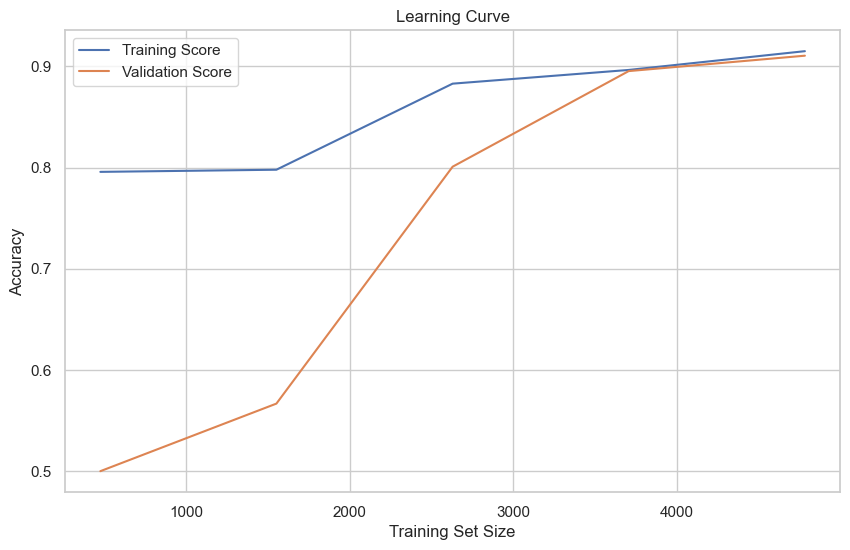

In [171]:
# Create a decision tree classifier with the best hyperparameters
best_dt_classifier = DecisionTreeClassifier(**random_search.best_params_)

# Fit the best classifier with the training data
best_dt_classifier.fit(X_train_resampled_tfid, y_train_resampled_tfid)

# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    best_dt_classifier, X_train_resampled_tfid, y_train_resampled_tfid, cv=5, scoring='accuracy'
)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

Confusion Matrix (Decision Tree) (Q4)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91      1305
           1       0.90      0.94      0.92      1305

    accuracy                           0.92      2610
   macro avg       0.92      0.92      0.92      2610
weighted avg       0.92      0.92      0.92      2610



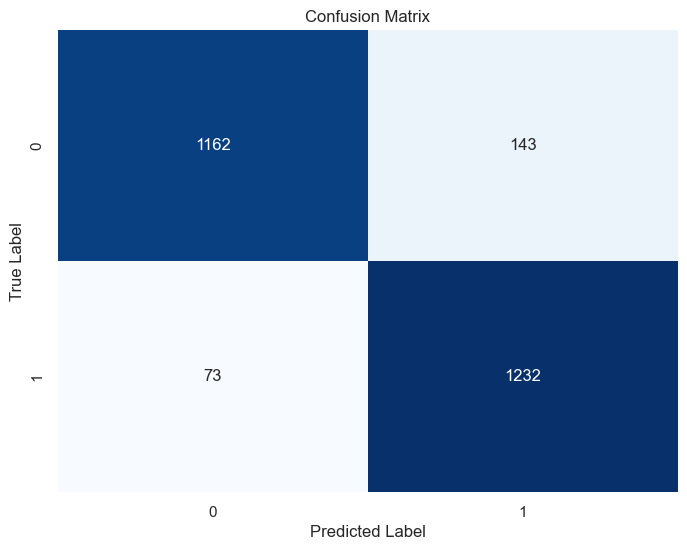

In [172]:
# Classification Report on the Test Set
y_pred = best_dt_classifier.predict(X_test_resampled_tfid)
print("Classification Report:\n", classification_report(y_test_resampled_tfid, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_resampled_tfid, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
